# Can money buy baseball wins? Let's try to answer that with SQL and Python

The life of a sports fan, while exciting, can also be frustrating: being outside of the action, you are often left to guesses and suppositions as to understand why your team is doing good, or bad... Among all the factors that can have an influence on the amount of wins a team can get throughout a season, the budget often comes in mind: "With a bigger budget, we could buy better players, and win more!" But is that true? This is the question we try to answer here.

To achieve this, we use the [Lahman's Baseball Database](http://www.seanlahman.com/baseball-archive/statistics/) that we have stored in a PostgreSQL database using PgAdmin (more info on the data source and database in the [readme](https://github.com/Nicolas-Schonau/SQL-and-the-Major-League-Baseball/blob/master/README.md) file). We focus on two main variables: the players' salaries and the total of wins per team during that season. 

To begin with, let us use SQL to get the needed data from the database, and then use Python to visualise data and see if there is a correlation between the payroll and the number of wins.

## SQL query

First, we need to query our tables to get the amount spent by each team in salaries, plus the number of wins they got.

So let's begin with our SQL query, which is actually a straightforward one if we take the time to break it down:
- We have two tables: ```salaries```, which contains the salaries for all players until 2016, and ```teams```, which contains all results for each team per year
- Both tables contain the teamid column, which is used as a key value to join them
- Let's start by querying the teamid and the sum of salaries for each player from the ```salaries``` table, and the number of wins per team from the  ```teams``` table
- Then let's join them on the teamid value with a ```INNER JOIN```
- We use a ```WHERE``` clause to ensure that we link the information for the same years in both tables (we want the salaries of year x to be linked with the wins of season x), and filter on the 2016 season (as this is the most recent data available)
- Optionnaly, if we want to analyse the table directly, we could order the values with the ```ORDER BY``` clause

This is our query:

```sql
SELECT sa.teamid, SUM(sa.salary) as payroll, te.w as wins
FROM salaries sa
INNER JOIN teams te on sa.teamid = te.teamid
WHERE sa.yearid = te.yearid AND sa.yearid = 2016
GROUP BY sa.teamid, te.w
ORDER BY payroll
;
```

Ran in PgAdmin, this query would return a table with the 3 columns ```teamid```, ```payroll``` and ```wins```, and the results for all 30 teams of the league. But for this exercice we do not execute it in PgAdmin, we save this query for later and first switch to Python.

## Python

We need to import the different librairies we are going to use for this analysis. 
We need 3 different ones:
- [psycopg2](https://pypi.org/project/psycopg2/) for the link with the PostgreSQL database
- [pandas](https://pandas.pydata.org/) for the dataframe and the correlation method
- [seaborn](https://seaborn.pydata.org/) in order to add a visualisation of our data

Let's import them:

In [1]:
import psycopg2 as pg2
import pandas as pd
import seaborn as sns

Now we have to make a connection to the database. Therefore, we use the connect function and set the correct values for the following parameters:
- database : pass the name of the database where the data is stored
- user : per default, PostgreSQL sets it to 'postgres'
- password : insert the password you use to connect to PostgreSQL/PgAdmin

We store all parameters inside the "conn" variable:

In [2]:
conn = pg2.connect(database='database_name', user='user_name', password="user_password")

Next, we create a "sql_2016" variable and pass the SQL query we wrote earlier as a string so that we are able to execute it afterwards:

In [3]:
sql_2016 = "SELECT sa.teamid, SUM(sa.salary) as payroll, te.w as wins FROM salaries sa INNER JOIN teams te on sa.teamid = te.teamid WHERE sa.yearid = te.yearid AND sa.yearid = 2016 GROUP BY sa.teamid, te.w ORDER BY payroll;"

Finally, let's run our query and import its output inside a 'dat' variable, and set it as a pandas dataframe:

In [4]:
dat = pd.read_sql_query(sql_2016, conn)
df = pd.DataFrame(data=dat)

And we are set! Let's start with a visual representation in order to have a first grasp of our results by calling the lmplot() function:

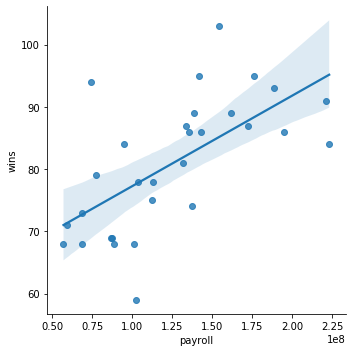

In [5]:
plot = sns.lmplot(x="payroll", y="wins", data=df)

Though there is some dispersion of the data, we can clearly see a positive trend linking the two variables. In order to quantify this correlation, we use the pearson correlation by calling the corr() function with the pearson method: 

In [6]:
df.corr(method ='pearson')

,payroll,wins
payroll,1.000000,0.636288
wins,0.636288,1.000000


And there it is! We now have our matrix telling us that there is a strong positive correlation (r=0.64) between wins and payroll, which means that indeed, the more a team spends in salary (and thus, invests in the quality of its players), the more it wins. 

Keep in mind this only applies to the 2016 season, our panel size is therefore of only 30 observations. We can add more seasons to our analysis and check if our conclusion still stands. Let's take all numbers starting from 2010 (we will not go before 2010 in order to avoid bias because of the inflation). 

We need to modify our SQL query by changing the value for yearid in the `WHERE` clause to >= 2010 and by adding the teamid column in the `SELECT` and `GROUP BY` clauses:

```sql
SELECT sa.teamid, sa.yearid, SUM(sa.salary) as payroll, te.w as wins
FROM salaries sa
INNER JOIN teams te on sa.teamid = te.teamid
WHERE sa.yearid = te.yearid AND sa.yearid >= 2010
GROUP BY sa.teamid, sa.yearid, te.w
ORDER BY payroll
;
```

Let's now rerun the steps we ran earlier: pass it into a variable, execute the sql query, set it as a dataframe and ask for a scatter plot:

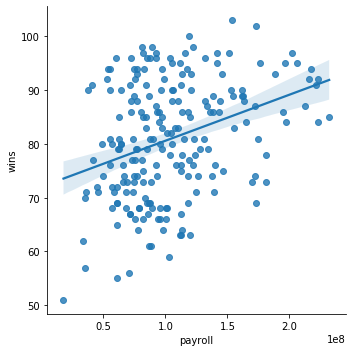

In [7]:
sql_from_2010 = "SELECT sa.teamid, sa.yearid, SUM(sa.salary) as payroll, te.w as wins FROM salaries sa INNER JOIN teams te on sa.teamid = te.teamid WHERE sa.yearid = te.yearid AND sa.yearid >= 2010 GROUP BY sa.teamid, sa.yearid, te.w ORDER BY payroll;"
dat_from_2010 = pd.read_sql_query(sql_from_2010, conn)
df_from_2010 = pd.DataFrame(data=dat_from_2010)
plot_from_2010 = sns.lmplot(x="payroll", y="wins", data=df_from_2010)

And now we can see that we have much more dispersion compared to our preliminary analysis! Let's quantify it by calling our correlation function. As the new sql query returns a table with a new column (i.e.: yearid), we use a slightly modified version of the correlation function:

In [8]:
df_from_2010['wins'].corr(df_from_2010['payroll'])

0.3394228209114813

As we notice, when we take several years into account, we actually get a correlation twice as low as we first observed (0.34 versus 0.63). There is still a positive link between both variables, but their connection is weaker than we thought. 

Plus, we cannot derive from this analysis that more wins are due to higher salaries spendings ("correlation does not imply causation"). Wins are influenced by a lot of factors: payroll, as we saw, but also the strategies of the teams, the strengths of their schedules, the injuries of players, etc. In a future development of this article, we'll try to explore other tracks, such as:
- comparing the salaries of year x versus the wins of year x-1 or x-2 : a team with one or two good seasons could see an increase in its revenues and thus afford more expensive players;
- On the opposite, comparing the salaries of year x versus the wins of year x+1 or x+2: maybe investing in more expensive players has only an impact one or two years later.

So if we want to answer our first question: yes, money can help winning, but it is not a key driver. Let this be a message of encouragement for small-market teams with reduced budget!

P.S.: Do not forget to close the connection to your database once your analysis is done! This can be easily done by executing the celle hereunder:

In [9]:
conn = None